In [2]:
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle

from keras.models import Model, load_model
from keras.layers import Input, SpatialDropout1D, Conv1D, Lambda, Dropout, Activation, Bidirectional, LSTM, Dense
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from livelossplot import PlotLossesKeras


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 
peaks['score'] = np.log(peaks['k27act'] + 1)

# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))
num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))
num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


In [4]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_counts_recurrent')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

print(out_path)

/home/kal/K27act_models/convolution_model/20180730_151934_counts_recurrent


In [17]:
# model's input
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
num_outputs=1

#build custom functions
def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

# add the rc, run throught the first lstm
add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
#reccur = Bidirectional(LSTM(64, return_sequences=True, activation='relu'), name='recurrent')(add_rc(seqs))
#recurr_dropped = Dropout(0.3)(reccur)

# run through another lstm but only get the end state
per_seqs = Bidirectional(LSTM(64, activation='relu'), name='seq_collapse')(add_rc(seqs))
per_seqs_dropped = Dropout(0.3)(per_seqs)

#out_dense = Dense(32, activation='relu')(per_seqs_dropped)
#out_dense_dropped = Dropout(0.3)(out_dense)
predictions = Dense(1, activation='relu')(per_seqs_dropped)


combined_preds = Lambda(lambda x: K.maximum(x[:x.shape[0]//2], x[x.shape[0]//2:]), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, 1))(predictions)

# make the predictions positive
#pos_predictions =  Activation('relu')(predictions)

# build the model
model = Model(inputs=seqs, outputs=combined_preds)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_seqs (InputLayer)      (32, 1024, 5)             0         
_________________________________________________________________
add_rc (Lambda)              (64, 1024, 5)             0         
_________________________________________________________________
seq_collapse (Bidirectional) (64, 128)                 35840     
_________________________________________________________________
dropout_13 (Dropout)         (64, 128)                 0         
_________________________________________________________________
dense_11 (Dense)             (64, 1)                   129       
_________________________________________________________________
stack_fr (Lambda)            (32, 1)                   0         
Total params: 35,969
Trainable params: 35,969
Non-trainable params: 0
_________________________________________________________________


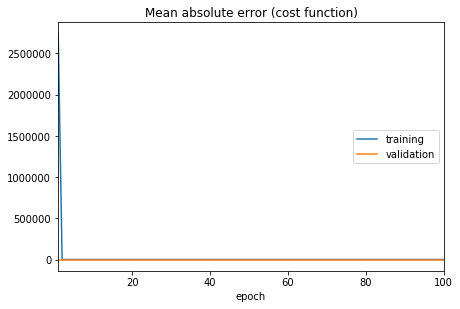

In [18]:
from keras.optimizers import RMSprop, SGD, Adam
%matplotlib inline


vpe = 20 # validations per epoch

opt = Adam(lr=1e-05)
model.compile(optimizer=opt, loss='mean_absolute_error') 

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-1-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train'), 
                             steps_per_epoch=num_training_samples//(batch_size*vpe), 
                             epochs=5*vpe, callbacks=[early_stop, checkpoint, PlotLossesKeras()], 
                             validation_data=datagen.batch_gen(peaks, mode='val'), 
                             validation_steps=num_validaiton_samples//(batch_size*vpe//5), verbose=2)

val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

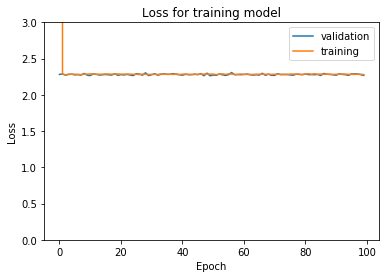

In [21]:
# look at loss
val_hist = np.asarray(val_hist).flatten()
train_hist = np.asarray(train_hist).flatten()
plt.plot(val_hist, label='validation')
plt.plot(train_hist, label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

In [22]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

# write out history
pickle.dump(losses.history, open(os.path.join(history_path, 'history.pk'), 'wb'))